In [13]:
import os
import sys
import matplotlib.pyplot as plt
import gensim
import pyLDAvis
import pyLDAvis.gensim

from gensim import corpora
from gensim import models
from gensim.models.coherencemodel import CoherenceModel

print('Python Version: %s' % (sys.version))
%matplotlib inline

Python Version: 3.7.3 (default, Mar 27 2019, 16:54:48) 
[Clang 4.0.1 (tags/RELEASE_401/final)]


## Load Everything
If you ever need to load dictionary, corpus and documents

In [14]:
import pickle
with open('/Users/storopoli/Desktop/temp/Topic-Modeling-RIAE/saved-objects/documents', 'rb') as f: #load
    documents = pickle.load(f)
with open('/Users/storopoli/Desktop/temp/Topic-Modeling-RIAE/saved-objects/texts', 'rb') as f: #load
    texts = pickle.load(f)
with open('/Users/storopoli/Desktop/temp/Topic-Modeling-RIAE/saved-objects/lemmatized_output', 'rb') as f: #load
    lemmatized_output = pickle.load(f)

dictionary = gensim.corpora.Dictionary.load('/Users/storopoli/Desktop/temp/Topic-Modeling-RIAE/saved-objects/dictionary.dict')
corpus = gensim.corpora.MmCorpus('/Users/storopoli/Desktop/temp/Topic-Modeling-RIAE/saved-objects/corpus.mm')

print(dictionary)
print(corpus)
print(len(documents))
print(len(lemmatized_output))

Dictionary(1025 unique tokens: ['compet', 'context', 'didá', 'empreg', 'estratég']...)
MmCorpus(164 documents, 1025 features, 5521 non-zero entries)
164
164


Choosing a `k` that marks the end of a rapid growth of topic coherence usually offers meaningful and interpretable topics. Picking an even higher value can sometimes provide more granular sub-topics.

If you see the same keywords being repeated in multiple topics, it’s probably a sign that the ‘k’ is too large.

The `compute_coherence_values()` (see below) trains multiple LDA models and provides the models and their corresponding coherence scores.

In [15]:
def compute_performance(dictionary, corpus, texts, limit, start=2, step=1, lda_type=None, mallet_path=None):
    """
    Compute c_v coherence and perplexity (if applicable) for various number of topics

    Parameters:
    ----------
    
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics
    lda_tpe : Type of LDA model from 3 options gensim for gensim.models.ldamodel.LdaModel, gensim-multicore for gensim.models.ldamulticore.LdaMulticore or mallet for gensim.models.wrappers.LdaMallet
    mallet_path : Full path of mallet-ver/bin/mallet

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    perplexity_values (if applicable) : Perplexity values corresponding to the LDA model with respective number of topics
    """
    import gensim
    coherence_values = []
    model_list = []
    perplexity_values = []
    if lda_type == 'gensim':
        for num_topics in range(start, limit, step):
            model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                    num_topics=num_topics, 
                                                    id2word=dictionary,
                                                    random_state=100,
                                                    update_every=1,
                                                    chunksize=100,
                                                    passes=10,
                                                    alpha='auto',
                                                    per_word_topics=True)
            model_list.append(model)
            coherencemodel = gensim.models.coherencemodel.CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
            coherence_values.append(coherencemodel.get_coherence())
            perplexity = model.log_perplexity(corpus)
            perplexity_values.append(perplexity)

        return model_list, coherence_values, perplexity_values
    
    elif lda_type == 'gensim-multicore':
        for num_topics in range(start, limit, step):
            model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                                            num_topics=num_topics, 
                                                            id2word=dictionary,
                                                            random_state=100,
                                                            chunksize=100,
                                                            passes=10,
                                                            alpha='symmetric',
                                                            per_word_topics=True)
            model_list.append(model)
            coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
            coherence_values.append(coherencemodel.get_coherence())
            perplexity = model.log_perplexity(corpus)
            perplexity_values.append(perplexity)

        return model_list, coherence_values, perplexity_values

    elif lda_type == 'mallet':
        if mallet_path == None:
            raise Exception('mallet_path should be specified')
        else:
            for num_topics in range(start, limit, step):
                model = gensim.models.wrappers.LdaMallet(mallet_path, 
                                                         corpus=corpus, 
                                                         num_topics=num_topics, 
                                                         id2word=dictionary)
                model_list.append(model)
                coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
                coherence_values.append(coherencemodel.get_coherence())

        return model_list, coherence_values

    else:
        print('Please specify which lda_type: gensim, gensim-multicore or mallet')

In [ ]:
model_list_1, coherence_values_1, perplexity_values_1 = compute_performance(dictionary=dictionary, 
                                                                                        corpus=corpus, 
                                                                                        texts=lemmatized_output, 
                                                                                        start=2, limit=40, step=1,
                                                                                        lda_type='gensim')

In [25]:
os.environ.update({'MALLET_HOME':r'/Users/storopoli/Desktop/temp/Topic-Modeling-RIAE/mallet-2.0.8/bin'})
mallet_path='/Users/storopoli/Desktop/temp/Topic-Modeling-RIAE/mallet-2.0.8/bin/mallet/bin'

In [26]:
# Can take a long time to run.
model_list_mallet, coherence_values_mallet = compute_performance(dictionary=dictionary, 
                                                        corpus=corpus, 
                                                        texts=lemmatized_output, 
                                                        start=2, limit=40, step=1,
                                                        lda_type='mallet',
                                                        mallet_path=mallet_path)

In [23]:
def graph_performance(model_list, coherence_values, perplexity_values=None, fname='performance LDA.jpg', dpi=300):
    """
    Graphics for visualizing the output of a compute performance for a LDA model list

    Parameters:
    ----------
    model_list : List of LDA topic models from a compute performance function
    coherence_values : Coherence values corresponding to the LDA models from a compute performance function
    perplexity_values : Perplexity values (if applicable) corresponding to the LDA models from a compute performance function
    fname : Filename to save figure
    dpi : Desired DPI for figure quality

    Returns:
    -------
    Saves a figure as a desired filename
    """
    import matplotlib.pyplot as plt
    x = range(2,2+len(model_list))
    
    if type(model_list[0]) == gensim.models.wrappers.ldamallet.LdaMallet:
        plt.plot(x, coherence_values)
        plt.xlabel("Num Topics")
        plt.ylabel("Coherence score")
        plt.legend(("coherence_values"), loc='best')
        plt.savefig(fname=fname, dpi=dpi)
        plt.show()
        # Print the coherence scores
        count = 0
        for m, cv in zip(x, coherence_values):
            print('Model number: ', count, "Num Topics =", m, " has Coherence Value of", round(cv, 3))
            count += 1
            
    elif type(model_list[0]) == gensim.models.ldamodel.LdaModel:
        fig, ax1 = plt.subplots()
        color = 'tab:red'
        plt.xlabel("Num Topics")
        plt.ylabel("Perplexity score", color=color)
        ax1.plot(x, perplexity_values, color=color)
        ax1.tick_params(axis='y', labelcolor=color)

        ax2 = ax1.twinx() # instantiate a second axes that shares the same x-axis
        color = 'tab:blue'
        ax2.set_ylabel('Coherence score', color=color)  # we already handled the x-label with ax1
        ax2.plot(x, coherence_values, color=color)
        ax2.tick_params(axis='y', labelcolor=color)

        fig.tight_layout()  # otherwise the right y-label is slightly clipped
        plt.savefig(fname=fname, dpi=dpi)
        plt.show()
        # Print the performance scores
        count = 0
        for m, cv, per in zip(x, coherence_values, perplexity_values):
            print('Model number: ', count, "Num Topics =", m, 
              " has Coherence Value of", round(cv, 3),
             " and Perplexity Valye of", round(per, 3))
            count += 1

In [111]:
range(2,2+len(model_list),1)

range(2, 40)

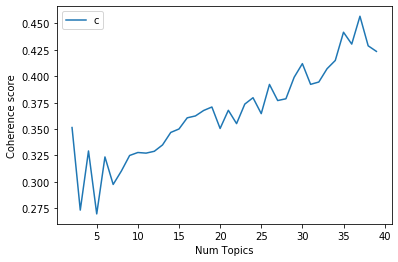

Model number:  0 Num Topics = 2  has Coherence Value of 0.351
Model number:  1 Num Topics = 3  has Coherence Value of 0.273
Model number:  2 Num Topics = 4  has Coherence Value of 0.329
Model number:  3 Num Topics = 5  has Coherence Value of 0.27
Model number:  4 Num Topics = 6  has Coherence Value of 0.324
Model number:  5 Num Topics = 7  has Coherence Value of 0.298
Model number:  6 Num Topics = 8  has Coherence Value of 0.31
Model number:  7 Num Topics = 9  has Coherence Value of 0.325
Model number:  8 Num Topics = 10  has Coherence Value of 0.328
Model number:  9 Num Topics = 11  has Coherence Value of 0.327
Model number:  10 Num Topics = 12  has Coherence Value of 0.329
Model number:  11 Num Topics = 13  has Coherence Value of 0.335
Model number:  12 Num Topics = 14  has Coherence Value of 0.347
Model number:  13 Num Topics = 15  has Coherence Value of 0.35
Model number:  14 Num Topics = 16  has Coherence Value of 0.361
Model number:  15 Num Topics = 17  has Coherence Value of 0.3

In [28]:
graph_performance(model_list_mallet, coherence_values_mallet, fname='/Users/storopoli/Desktop/temp/Topic-Modeling-RIAE/images/LDA-Mallet.jpg')

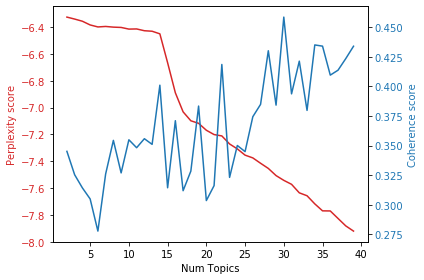

Model number:  0 Num Topics = 2  has Coherence Value of 0.345  and Perplexity Valye of -6.325
Model number:  1 Num Topics = 3  has Coherence Value of 0.325  and Perplexity Valye of -6.34
Model number:  2 Num Topics = 4  has Coherence Value of 0.314  and Perplexity Valye of -6.356
Model number:  3 Num Topics = 5  has Coherence Value of 0.305  and Perplexity Valye of -6.384
Model number:  4 Num Topics = 6  has Coherence Value of 0.278  and Perplexity Valye of -6.399
Model number:  5 Num Topics = 7  has Coherence Value of 0.326  and Perplexity Valye of -6.395
Model number:  6 Num Topics = 8  has Coherence Value of 0.354  and Perplexity Valye of -6.4
Model number:  7 Num Topics = 9  has Coherence Value of 0.327  and Perplexity Valye of -6.402
Model number:  8 Num Topics = 10  has Coherence Value of 0.355  and Perplexity Valye of -6.415
Model number:  9 Num Topics = 11  has Coherence Value of 0.348  and Perplexity Valye of -6.414
Model number:  10 Num Topics = 12  has Coherence Value of 0.3

In [74]:
graph_performance(model_list_1, coherence_values_1, perplexity_values_1, fname='LDA-Gensim.jpg')

In [32]:
# Select the model and print the topics
optimal_model = model_list_mallet[4]
model_topics = optimal_model.show_topics(formatted=True)
optimal_model.print_topics(num_words=10)

[(0,
  '0.212*"estratég" + 0.049*"organiz" + 0.042*"competi" + 0.040*"prát" + 0.036*"merc" + 0.036*"conceit" + 0.035*"empr" + 0.022*"vantag" + 0.018*"gerenc" + 0.016*"comport"'),
 (1,
  '0.055*"gest" + 0.047*"teor" + 0.042*"negóci" + 0.027*"internac" + 0.024*"caracterís" + 0.022*"futur" + 0.021*"decis" + 0.020*"abord" + 0.018*"país" + 0.017*"relacion"'),
 (2,
  '0.080*"desenvolv" + 0.043*"ambi" + 0.032*"inform" + 0.030*"empreend" + 0.029*"públic" + 0.026*"sustent" + 0.025*"instituc" + 0.023*"institu" + 0.022*"internacion" + 0.022*"empreendedor"'),
 (3,
  '0.090*"process" + 0.037*"conhec" + 0.030*"entrev" + 0.030*"context" + 0.028*"qualit" + 0.023*"perspec" + 0.023*"form" + 0.023*"particip" + 0.020*"envolv" + 0.018*"mudanç"'),
 (4,
  '0.125*"empr" + 0.043*"fat" + 0.042*"recurs" + 0.040*"brasil" + 0.032*"ativ" + 0.026*"estrut" + 0.023*"corpor" + 0.022*"financ" + 0.019*"efici" + 0.019*"capit"'),
 (5,
  '0.084*"inov" + 0.082*"desempenh" + 0.067*"capac" + 0.062*"organizac" + 0.059*"model" +

In [34]:
optimal_model.save('/Users/storopoli/Desktop/temp/Topic-Modeling-RIAE/saved-objects/optimal_model_6_topics')

In [105]:
# Visualize the topics
model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(optimal_model)
#model = optimal_model
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model, corpus, dictionary)

/home/storopoli/anaconda3/envs/topic-modeling/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/home/storopoli/anaconda3/envs/topic-modeling/lib/python3.7/site-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
/home/storopoli/anaconda3/envs/topic-modeling/lib/python3.7/site-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
/home/storopoli/anaconda3/envs/topic-modeling/lib/python3.7/site-packages/pyLDAvis/_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topi

In [84]:
# Visualize the topics
#model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(optimal_model)
model = optimal_model
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model, corpus, dictionary)

/home/storopoli/anaconda3/envs/topic-modeling/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/home/storopoli/anaconda3/envs/topic-modeling/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/home/storopoli/anaconda3/envs/topic-modeling/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort b

In [106]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.113037 -0.265247       1        1  16.994207
0     -0.275932 -0.071169       2        1  16.932809
1      0.221234 -0.018665       3        1  16.919601
4     -0.296769  0.028569       4        1  16.861139
2      0.084299  0.391983       5        1  16.496369
5      0.154130 -0.065470       6        1  15.795875, topic_info=    Category        Freq         Term       Total  loglift  logprob
4    Default  310.000000     estratég  310.000000  30.0000  30.0000
33   Default  226.000000         empr  226.000000  29.0000  29.0000
201  Default  125.000000         inov  125.000000  28.0000  28.0000
27   Default  122.000000    desempenh  122.000000  27.0000  27.0000
72   Default  130.000000      process  130.000000  26.0000  26.0000
22   Default  100.000000        capac  100.000000  25.0000  25.0000
93   Default   93.000000         gest   93.000000  24.0000  24.0000
9    Default   92.000000    organizac   92.000000  23.0000  23.0000
98   Default   89.000000      organiz   89.000000  22.0000  22.0000
67   Default   87.000000        model   87.000000  21.0000  21.0000
21   Default   73.000000       brasil   73.000000  20.0000  20.0000
46   Default   66.000000         teor   66.000000  19.0000  19.0000
38   Default   61.000000          fat   61.000000  18.0000  18.0000
28   Default  101.000000    desenvolv  101.000000  17.0000  17.0000
82   Default   62.000000      competi   62.000000  16.0000  16.0000
15   Default   59.000000         prát   59.000000  15.0000  15.0000
318  Default   58.000000       recurs   58.000000  14.0000  14.0000
19   Default   55.000000         ambi   55.000000  13.0000  13.0000
109  Default   53.000000       conhec   53.000000  12.0000  12.0000
66   Default   53.000000         merc   53.000000  11.0000  11.0000
53   Default   53.000000      conceit   53.000000  10.0000  10.0000
44   Default   46.000000     relacion   46.000000   9.0000   9.0000
193  Default   45.000000         ativ   45.000000   8.0000   8.0000
34   Default   43.000000       entrev   43.000000   7.0000   7.0000
64   Default   45.000000        indic   45.000000   6.0000   6.0000
86   Default   40.000000       dimens   40.000000   5.0000   5.0000
87   Default   37.000000     empreend   37.000000   4.0000   4.0000
358  Default   37.000000     internac   37.000000   3.0000   3.0000
176  Default   40.000000       inform   40.000000   2.0000   2.0000
331  Default   36.000000         form   36.000000   1.0000   1.0000
..       ...         ...          ...         ...      ...      ...
19    Topic6   55.235479         ambi   55.235479   1.8454  -3.1903
87    Topic6   37.846532     empreend   37.846532   1.8454  -3.5684
358   Topic6   37.846532     internac   37.846532   1.8454  -3.5684
103   Topic6   33.755015      sustent   33.755015   1.8454  -3.6828
6     Topic6   32.732136        futur   32.732136   1.8454  -3.7136
359   Topic6   27.617740  internacion   27.617740   1.8454  -3.8835
106   Topic6   23.526223       acadêm   23.526223   1.8454  -4.0438
70    Topic6   19.434706        polít   19.434706   1.8454  -4.2349
96    Topic6   17.388947        lacun   17.388947   1.8454  -4.3461
120   Topic6   17.388947       produç   17.388947   1.8454  -4.3461
46    Topic6   65.464272         teor   66.480165   1.8300  -3.0204
556   Topic6   13.297430   management   13.297430   1.8454  -4.6144
538   Topic6   12.274551    marketing   12.274551   1.8454  -4.6944
531   Topic6   12.274551   bibliométr   12.274551   1.8454  -4.6944
5     Topic6   12.274551       evoluç   12.274551   1.8454  -4.6944
536   Topic6   11.251672        fator   11.251672   1.8454  -4.7814
330   Topic6   11.251672   exploratór   11.251672   1.8454  -4.7814
229   Topic6   11.251672         orig   11.251672   1.8454  -4.7814
371   Topic6   10.228792       demand   10.228792   1.8454  -4.8767
234   Topic6   10.228792         text   10.228792   1.845

In [107]:
pyLDAvis.save_html(vis, 'lDAvis-6-topics.html')